#  Análisis precios diarios mercado eléctrico español

## 1. Importamos Librerías

In [10]:
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import datetime,timedelta,date
from scipy.stats import spearmanr # para calcular correlaciones y pvalores
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange, num2date, date2num)
import matplotlib.patches as mpatches
import matplotlib.units as munits
from matplotlib.dates import num2date, date2num


import yfinance as yf
import seaborn as sns
import pyodbc
import requests
import json






## 1.1 Carga de datasets

Extraemos los datos de yahoo finance de futuros del Barril Brent y del Gas.

In [11]:
Barril_Brent = yf.download('BZ=F', start='2014-01-01', end='2018-01-30')

[*********************100%***********************]  1 of 1 completed


In [12]:
Precios_Brent = Barril_Brent['Close']

Vamos a realizar un vistazo rápido a las diferentes series temporales.

Text(0, 0.5, 'Precio de Cierre ($/Barril)')

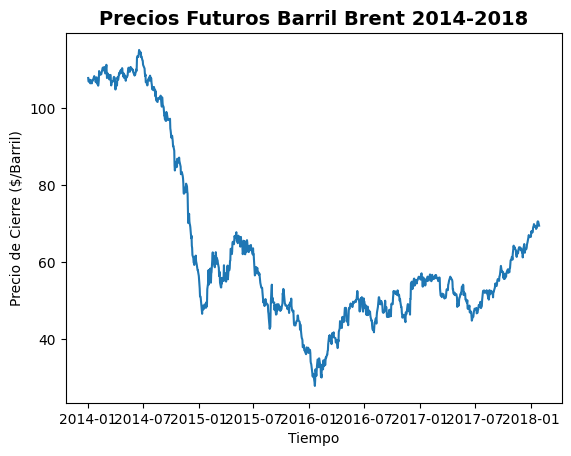

In [28]:
sns.lineplot(Precios_Brent).set_title('Precios Futuros Barril Brent 2014-2018',fontweight='bold', fontsize=14)
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre ($/Barril)')

In [14]:
Futuros_Gas = yf.download('NG=F', start='2014-01-01', end='2018-01-30')

[*********************100%***********************]  1 of 1 completed


In [15]:
Precios_Gas = Futuros_Gas['Close']

Text(0, 0.5, 'Precio de Cierre ($/m3)')

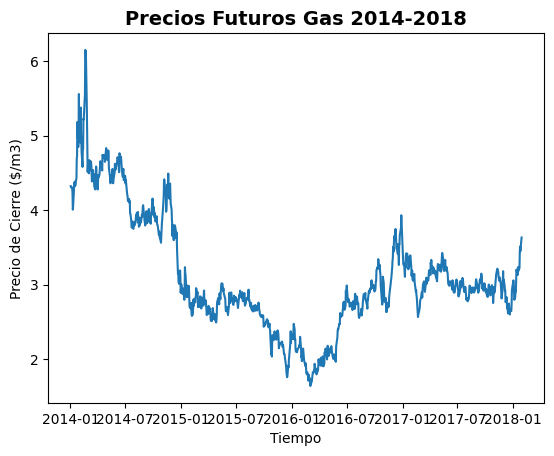

In [27]:
sns.lineplot(Precios_Gas).set_title('Precios Futuros Gas 2014-2018',fontweight='bold', fontsize=14)
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre ($/m3)')

A continuación, podemos utilizar pyodbc para conectarnos a la base de datos y leer los datos.
La fuente es una base de datos que contiene las reservas hídricas de España por año.
La hemos obtenido de Boletines hidrológicos. Ministerio para la Transición Ecológica, Gobierno de España.
link = https://datos.gob.es/es/catalogo/e05068001-boletin-hidrologico-semanal

In [17]:
# Conexión a la base de datos de Access
conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=./data/BD-Embalses.mdb;'
)
conn = pyodbc.connect(conn_str)

# Consulta SQL para seleccionar los datos
sql = "SELECT EMBALSE_NOMBRE, FECHA, AGUA_TOTAL, AGUA_ACTUAL FROM T_Embalses"
df = pd.read_sql(sql, conn)

# Cerrar la conexión a la base de datos
conn.close()

Leemos los datasets extraídos de Kaggle.

In [18]:
energydf=pd.read_csv('./data/spain_energy_market.csv', parse_dates=True, index_col=0)
weatherdf=pd.read_csv('./data/weather_features.csv', parse_dates=True, index_col='dt_iso')

## 2. Transformaciones para limpiar y preparar los datos

In [19]:
# Convertir la columna 'FECHA' a formato de fecha y hora
df['FECHA'] = pd.to_datetime(df['FECHA'])



In [20]:
df['AGUA_ACTUAL'] = df['AGUA_ACTUAL'].str.replace(',', '.').astype(float)
df['AGUA_TOTAL'] = df['AGUA_TOTAL'].str.replace(',', '.').astype(float)

In [21]:
reservas_anuales = df.groupby(df['FECHA'])['AGUA_ACTUAL'].sum()

In [22]:
reservas_anuales.index = reservas_anuales.index.strftime('%Y-%m-%d')


In [23]:
reservas_anuales_filtradas = reservas_anuales.loc['2014-01-01':'2018-12-31']

Text(0, 0.5, 'Agua (hm3)')

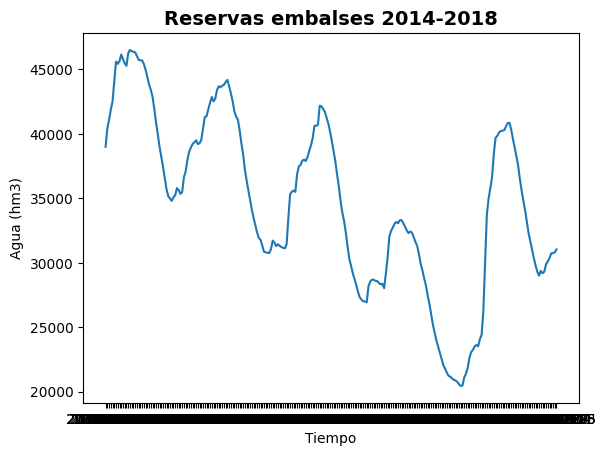

In [24]:
ax = sns.lineplot(data=reservas_anuales_filtradas)
ax.set_title('Reservas embalses 2014-2018',fontweight='bold', fontsize=14)
plt.xlabel('Tiempo')
plt.ylabel('Agua (hm3)')

El agua de los embalses está disminuyendo podría indicar sequías continuas debido al cambio climático podríamos inferir.

In [95]:
#Selecciono los precios del mercado español que son los que me interesan
energydf_filtered = energydf.loc[energydf['name'] == 'Precio mercado SPOT Diario ESP']


Text(0, 0.5, 'Precios (€/MW/h)')

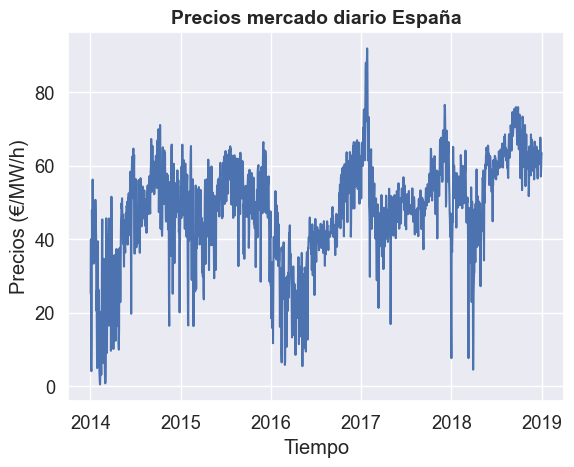

In [96]:
# gráfico para observar cómo han evolucionado los precios
sns.lineplot(data=energydf_filtered, x='datetime',y='value',).set_title('Precios mercado diario España',fontweight='bold', fontsize=14)
plt.xlabel('Tiempo')
plt.ylabel('Precios (€/MW/h)')

Se observa una tendencia del aumento de precios.

In [97]:
Precios_Brent.index.name = 'fecha'
energydf_filtered.index.name = 'fecha'
Precios_Gas.index.name = 'fecha'
Precios_Gas = Precios_Gas.rename('Futuros Gas')
Precios_Brent = Precios_Brent.rename('Futuros Brent')

In [98]:
energydf_filtered.index = pd.to_datetime(energydf_filtered.index)
energydf_filtered = energydf_filtered.resample('D').mean()
energydf_filtered.index = energydf_filtered.index.normalize()

In [99]:
Precios_Brent.index = pd.to_datetime(Precios_Brent.index)
Precios_Brent = Precios_Brent.resample('D').mean()
Precios_Brent.index = Precios_Brent.index.normalize()

In [100]:
Precios_Gas.index = pd.to_datetime(Precios_Gas.index)
Precios_Gas = Precios_Gas.resample('D').mean()
Precios_Gas.index = Precios_Gas.index.normalize()

In [101]:
weatherdf.index = pd.to_datetime(weatherdf.index, utc=True)
weatherdf = weatherdf.resample('D').mean()
weatherdf.index = weatherdf.index.normalize()


In [102]:
reservas_anuales_filtradas.index = pd.to_datetime(reservas_anuales_filtradas.index)
reservas_anuales_filtradas = reservas_anuales_filtradas.resample('D').mean()
reservas_anuales_filtradas.index = reservas_anuales_filtradas.index.normalize()

In [103]:
start_date = '2014-01-01'
end_date = '2018-12-31'
merged_df = pd.concat([energydf_filtered,Precios_Brent,Precios_Gas,reservas_anuales_filtradas],axis=1,)


In [104]:
# No se puede mezclar dataframe localizados con no localizados
weatherdf.index = weatherdf.index.tz_localize(None)

Realizaremos un merge para tener todos los datos en un dataframe y trabajar con él.

In [105]:
merged_df = pd.concat([merged_df,weatherdf],axis=1,)

In [106]:
#Por último voy a renombrar las columnas para que Juan esté contento y estén todas en el mismo idioma.
merged_df.rename_axis('fecha', inplace=True)
merged_df.rename(columns={'value': 'precio'}, inplace=True)
merged_df.rename(columns={'AGUA_ACTUAL': 'agua_embalses'}, inplace=True)
merged_df.rename(columns={'pressure': 'presion'}, inplace=True)
merged_df.rename(columns={'wind_speed': 'viento'}, inplace=True)
merged_df.rename(columns={'humidity': 'humedad'}, inplace=True)
merged_df.rename(columns={'clouds_all': 'nubes'}, inplace=True)
merged_df.rename(columns={'rain_1h': 'lluvia'}, inplace=True)
merged_df.rename(columns={'snow_3h': 'nieve'}, inplace=True)

Eliminamos las columnas redundantes para tener solo los datos que necesitamos.

In [107]:
#elimino las columnas redundantes para quedarme con las que me interesan solo
merged_df = merged_df.drop(['id','geoid','wind_deg', 'rain_3h', 'weather_id','temp_min','temp_max'], axis=1)

Ya tenemos listo nuestro conjunto de datos para trabajar con él.

# 3. Análisis de correlaciones y contrastes de hipótesis.

Un mapa de correlaciones nos puede ayudar a identificar las posibles variables que puedan tener un peso sobre los precios.

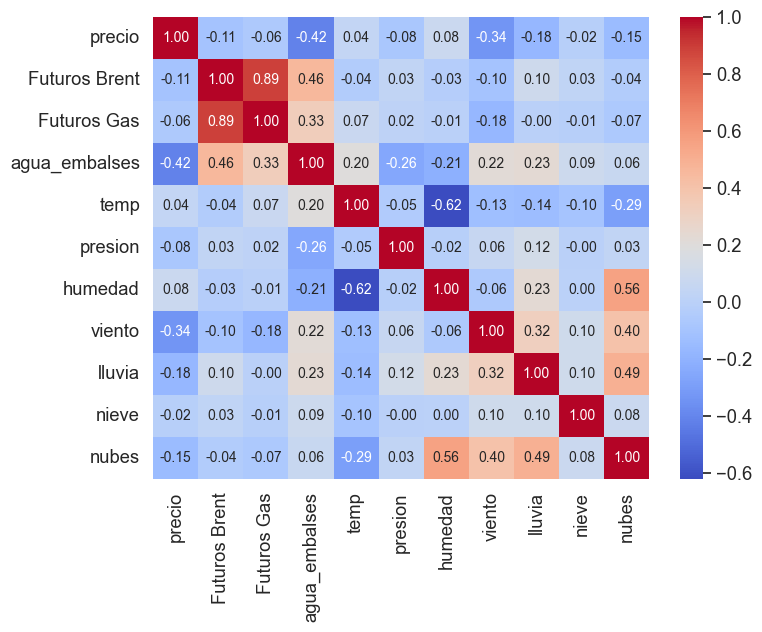

In [108]:

# Ajustar el tamaño de la figura y los elementos en el mapa de calor
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})

# Mostrar la figura
plt.show()

Realizamos el método de spearman también ya que es mejor para variables que no siguen una distribución normal. Aunque se puede ver a simple vista, lo demostraremos a continuación con el test de Shapiro-Wilk.

In [109]:

# Realizar la prueba de normalidad de Shapiro-Wilk
shapiro_test = shapiro(merged_df['precio'])

# Mostrar el resultado de la prueba de normalidad
print(f"Estadístico de prueba: {shapiro_test.statistic:.4f}")
print(f"Valor p: {shapiro_test.pvalue:.4f}")

# Evaluar la hipótesis nula (H0) de normalidad
if shapiro_test.pvalue > 0.05:
    print("La variable sigue una distribución normal")
else:
    print("La variable no sigue una distribución normal")

Estadístico de prueba: 0.9639
Valor p: 0.0000
La variable no sigue una distribución normal


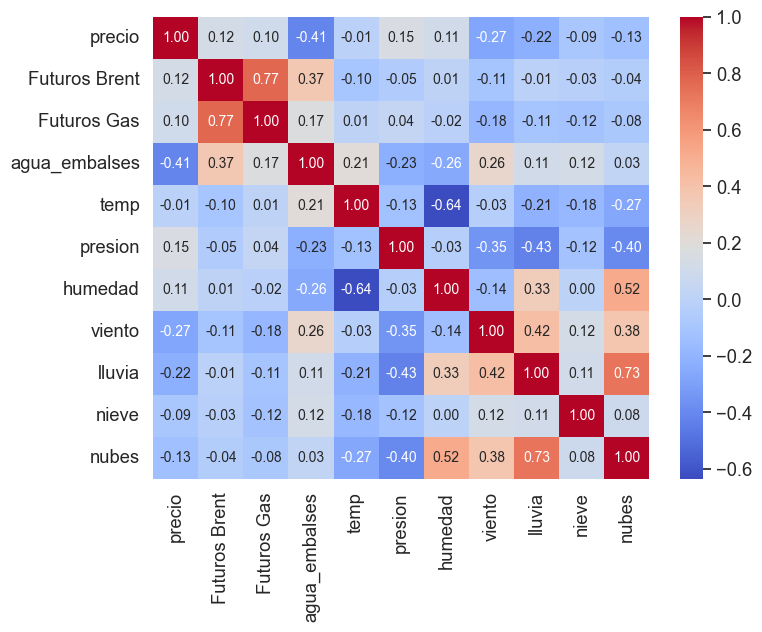

In [110]:

# Ajustar el tamaño de la figura y los elementos en el mapa de calor
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(merged_df.corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})

# Mostrar la figura
plt.show()

Elimino para este cálculo los NA correspondientes a las dos columnas a evaluar, ya que el método pearson no admite valores faltantes. Y así minimizar la pérdida de datos.

In [111]:
df_corr = merged_df[['precio', 'agua_embalses']].dropna() # Eliminar valores faltantes de las columnas especificadas
coeficiente_corr, valor_p = spearmanr(df_corr['precio'], df_corr['agua_embalses'])

Planteamos la hipótesis para realizar el contraste:

* H0: No hay correlación entre los precios y el nivel de agua en los embalses.
* H1: Existe una correlación entre los precios y el nivel de agua en los embalses.

In [112]:
# Imprimir el coeficiente de correlación y el valor p
print("Coeficiente de correlación de Pearson:", coeficiente_corr)
print("Valor p:", valor_p)

# Realizar el contraste de hipótesis
nivel_confianza = 0.05 # Nivel de confianza típico
if valor_p < nivel_confianza:
    print("Rechazamos la hipótesis nula. Existe una correlación significativa entre los precios y el nivel de agua en los embalses.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar que existe una correlación significativa entre los precios y el nivel de agua en los embalses.")

Coeficiente de correlación de Pearson: -0.4117754191846102
Valor p: 4.6137297388030775e-12
Rechazamos la hipótesis nula. Existe una correlación significativa entre los precios y el nivel de agua en los embalses.


Vamos a graficar para obtener una comprensión visual.

<AxesSubplot:xlabel='agua_embalses', ylabel='precio'>

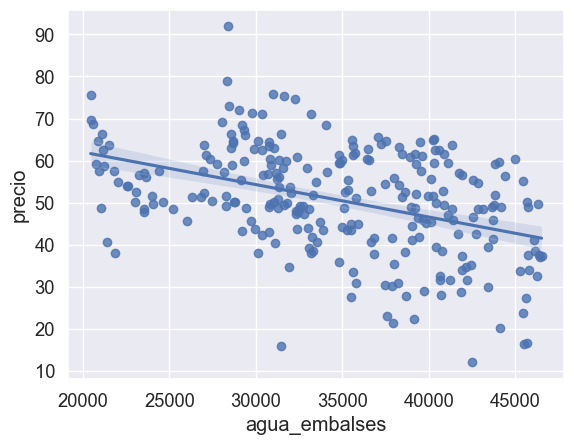

In [113]:
# Crear un gráfico de dispersión con línea de regresión
sns.regplot(x="agua_embalses", y="precio", data=df_corr)

Otra variable que puede afectar es el viento, vamos a comprobar estadísticamente si es así.

In [114]:
df_corr = merged_df[['precio', 'viento']].dropna() # Eliminar valores faltantes de las columnas especificadas
coeficiente_corr, valor_p = spearmanr(df_corr['precio'], df_corr['viento'])

Planteamos la hipótesis para realizar el contraste:

* H0: No hay correlación entre los precios y la velocidad del viento.
* H1: Existe una correlación entre los precios y la velocidad del viento.

In [115]:
# Imprimir el coeficiente de correlación y el valor p
print("Coeficiente de correlación de Pearson:", coeficiente_corr)
print("Valor p:", valor_p)

# Realizar el contraste de hipótesis
nivel_confianza = 0.05 # Nivel de confianza típico
if valor_p < nivel_confianza:
    print("Rechazamos la hipótesis nula. Existe una correlación significativa entre los precios y la velocidad del viento.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar que existe una correlación significativa entre los precios y la velocidad del vineto.")

Coeficiente de correlación de Pearson: -0.27344655574115445
Valor p: 1.7396692874687102e-26
Rechazamos la hipótesis nula. Existe una correlación significativa entre los precios y la velocidad del viento.


Se obtiene relación significativa con lo cual procedemos a una representación visual.

<AxesSubplot:xlabel='viento', ylabel='precio'>

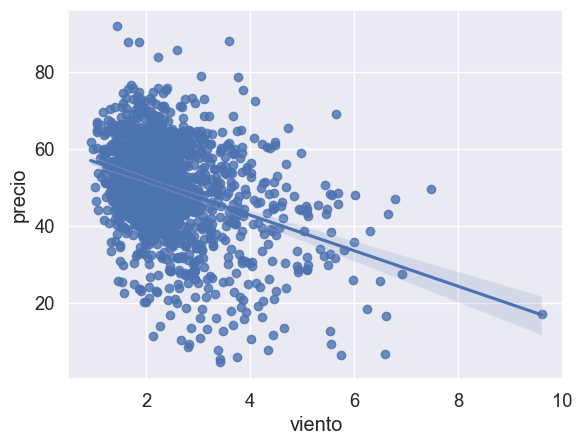

In [116]:
# Creamos un gráfico de dispersión con línea de regresión
sns.regplot(x="viento", y="precio", data=df_corr)

# 4. Modelo multivariante lineal

Vamos a intentar hacer una regresión multivariante simple con lo que hemos visto en clase

In [117]:
df_corr = merged_df[['precio','viento','agua_embalses']].dropna()

In [118]:
df_corr.tail(3)

,precio,viento,agua_embalses
fecha,,,
2018-12-11,64.510833,1.811475,30755.0
2018-12-18,60.294167,2.650000,30804.0
2018-12-25,62.993333,1.515873,31040.0


Como podemos ver, el último valor del dataset es 63 €MW/h. Esto es importante, ya que vamos a sustraer esa fila para intentar predecir ese valor con el modelo.

In [119]:
df_corr = df_corr.drop(df_corr.index[-1]) #al ponerle -1 el índice es la última fila


In [120]:

# Separar las variables independientes y la variable dependiente
x = df_corr[["viento", "agua_embalses"]]
y = df_corr["precio"]

# Crear el modelo de regresión
modelo = LinearRegression()

# Ajustar el modelo a los datos
modelo.fit(x, y)

# Imprimir los coeficientes de regresión
print("Coeficientes de regresión:", modelo.coef_)

# Predecir valores para nuevas observaciones
nueva_observacion = [[1.515873, 31040]] # le damos los valores de las variables dependientes de la última fila que quitamos anteriormente
prediccion = modelo.predict(nueva_observacion)
print("Predicción:", prediccion)

Coeficientes de regresión: [-3.77429108e+00 -5.48108720e-04]
Predicción: [56.38954099]


c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


Aprovechando que el modelo lineal depende solo de 2 variables, realizamos un gráfico en 3 dimensiones que representa cómo varía el precio en función de esas variables.

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


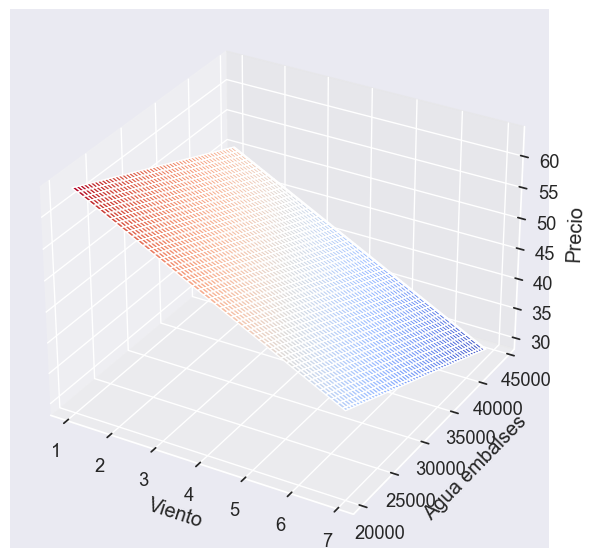

In [121]:
# valores de predicción
viento_pred = np.linspace(x["viento"].min(), x["viento"].max(), 100)
agua_embalses_pred = np.linspace(x["agua_embalses"].min(), x["agua_embalses"].max(), 100)
# Se crea matriz 2D con todas las combinaciones posibles de viento y agua_embalses
VIENTO, AGUA_EMBALSES = np.meshgrid(viento_pred, agua_embalses_pred)
VALORES_PREDICHOS = modelo.predict(np.array([VIENTO.ravel(), AGUA_EMBALSES.ravel()]).T).reshape(VIENTO.shape)
# Graficamos en 3d
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(VIENTO, AGUA_EMBALSES, VALORES_PREDICHOS, cmap='coolwarm')
ax.set_xlabel('Viento')
ax.set_ylabel('Agua embalses')
ax.set_zlabel('Precio')
plt.show()


Usaremos la métrica del error porcentual absoluto medio (MAPE)

In [122]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
mape = mean_absolute_percentage_error(62.993333, prediccion)
print('{:.2f}%'.format(mape))

10.48%


Como podemos ver, se ha desviado en términos porcentuales casi un 10.5% del valor real.
Algo que no está mal teniendo en cuenta las limitaciones del modelo y las correlaciones pobres en intensidad.